# Getting a Model

Interesting Observations About Dataset
- May be imbalanced data - what percent of houses are sold within 60 days?
- Time series data - there are definitely times of the year where the market is hotter than other times

In [309]:
%run src/imports.py

In [310]:
sns.set(rc={'figure.figsize':(16,4)})

In [311]:
neighborhoods_cleaned = pd.read_pickle('data/neighborhoods_cleaned.pkl')

In [312]:
neighborhoods_cleaned.reset_index(inplace=True)

In [313]:
neighborhoods_cleaned.drop('index',axis=1,inplace=True)

In [314]:
neighborhoods_cleaned.head()

,SOLD DATE,PROPERTY TYPE,ADDRESS,CITY,STATE OR PROVINCE,ZIP OR POSTAL CODE,PRICE,LOCATION,LOT SIZE,YEAR BUILT,DAYS ON MARKET,$/SQUARE FEET,HOA/MONTH,LATITUDE,LONGITUDE,ROOMS PER SQFT * 1000
0,September-25-2020,Single Family Residential,6702 Frua Ln,San Antonio,TX,78257,345000,The Dominion,5662.0,2005.0,170.0,173.0,230.0,29.647801,-98.614186,2.011061
1,June-11-2020,Single Family Residential,315 Persimmon Trl,San Antonio,TX,78256,337500,Stonewall Ranch,9583.0,2004.0,276.0,156.0,54.0,29.650304,-98.629082,2.770083
2,March-11-2021,Single Family Residential,610 Cypress Trl,San Antonio,TX,78256,375500,Stonewall Ranch,6605.0,2004.0,3.0,126.0,54.0,29.651842,-98.630650,2.189289
3,October-31-2018,Single Family Residential,18342 Branson Fls,San Antonio,TX,78255,462000,The Ridge @ Sonoma Verde,9147.0,2014.0,865.0,170.0,95.0,29.617650,-98.643430,2.577320
4,February-26-2021,Single Family Residential,6611 Sierra Oaks,San Antonio,TX,78256,624000,Crownridge,75794.0,2000.0,16.0,207.0,25.0,29.620646,-98.622295,1.826029


In [243]:
pd.get_dummies(neighborhoods_cleaned['LOCATION'],drop_first=True)

,Alamo Heights,Alamo Ranch,Alta Vista,Amhurst,Apple Creek,Arbor At Sonoma Ranch,Arcadia Ridge,Asher Place,Auburn Hills At Woodcrest,Autumn Run,...,Wildhorse,Wildhorse At Tausch Farms,Willow Grove Sub (sc),Wilshire Terrace,Wilshire Village,Windcrest,Wolf Creek,Woodcrest,Woodlake,Woods Of Shavano
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20007,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20008,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20009,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20010,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [249]:
neighborhoods_cleaned = neighborhoods_cleaned.merge(pd.get_dummies(neighborhoods_cleaned['LOCATION'],drop_first=True), how='outer',left_index=True,right_index=True)

In [250]:
neighborhoods_cleaned

,SOLD DATE,PROPERTY TYPE,ADDRESS,CITY,STATE OR PROVINCE,ZIP OR POSTAL CODE,PRICE,LOCATION,LOT SIZE,YEAR BUILT,...,Wildhorse,Wildhorse At Tausch Farms,Willow Grove Sub (sc),Wilshire Terrace,Wilshire Village,Windcrest,Wolf Creek,Woodcrest,Woodlake,Woods Of Shavano
0,September-25-2020,Single Family Residential,6702 Frua Ln,San Antonio,TX,78257,345000,The Dominion,5662.0,2005.0,...,0,0,0,0,0,0,0,0,0,0
1,June-11-2020,Single Family Residential,315 Persimmon Trl,San Antonio,TX,78256,337500,Stonewall Ranch,9583.0,2004.0,...,0,0,0,0,0,0,0,0,0,0
2,March-11-2021,Single Family Residential,610 Cypress Trl,San Antonio,TX,78256,375500,Stonewall Ranch,6605.0,2004.0,...,0,0,0,0,0,0,0,0,0,0
3,October-31-2018,Single Family Residential,18342 Branson Fls,San Antonio,TX,78255,462000,The Ridge @ Sonoma Verde,9147.0,2014.0,...,0,0,0,0,0,0,0,0,0,0
4,February-26-2021,Single Family Residential,6611 Sierra Oaks,San Antonio,TX,78256,624000,Crownridge,75794.0,2000.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20007,September-26-2019,Single Family Residential,5926 Whispering Lake St,San Antonio,TX,78222,153000,Lakeside,6969.0,1983.0,...,0,0,0,0,0,0,0,0,0,0
20008,July-30-2018,Single Family Residential,5510 Goliad Sand,San Antonio,TX,78222,189900,Riposa Vita,4791.0,2018.0,...,0,0,0,0,0,0,0,0,0,0
20009,March-25-2019,Single Family Residential,5931 Pleasant Lk,San Antonio,TX,78222,128000,Lakeside,5662.0,1985.0,...,0,0,0,0,0,0,0,0,0,0
20010,March-29-2019,Single Family Residential,6006 Bear Br,San Antonio,TX,78222,196499,Foster Meadows,5662.0,2014.0,...,0,0,0,0,0,0,0,0,0,0


In [215]:
### Categorize based on days on market

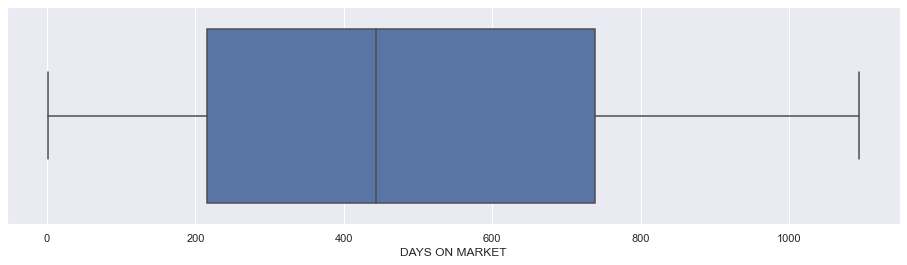

In [251]:
ax = sns.boxplot(x=neighborhoods_cleaned['DAYS ON MARKET'])

In [322]:
neighborhoods_cleaned['DAYS ON MARKET'].describe()

count    20012.000000
mean       487.568259
std        316.775850
min          1.000000
25%        216.000000
50%        443.500000
75%        739.000000
max       1095.000000
Name: DAYS ON MARKET, dtype: float64

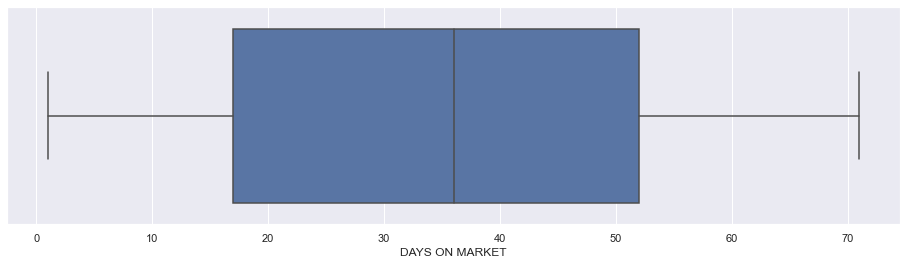

In [321]:
ax = sns.boxplot(x=df2021['DAYS ON MARKET'])

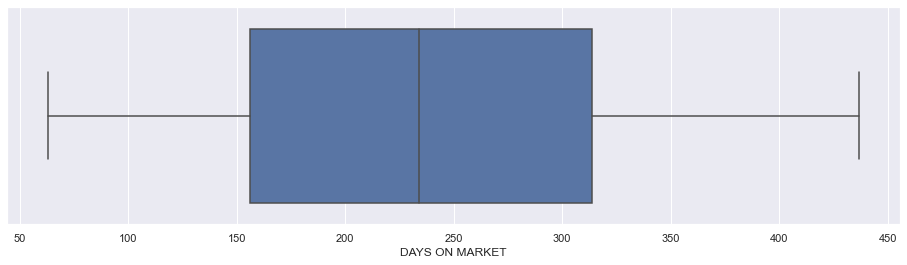

In [325]:
ax = sns.boxplot(x=df2020['DAYS ON MARKET'])

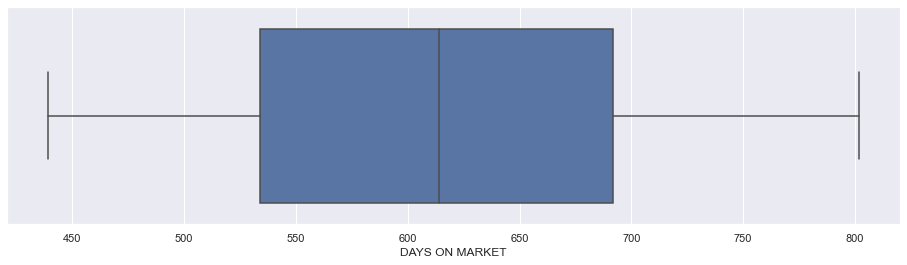

In [326]:
ax = sns.boxplot(x=df2019['DAYS ON MARKET'])

In [323]:
df2021['DAYS ON MARKET'].describe()

count    1257.000000
mean       35.020684
std        19.197877
min         1.000000
25%        17.000000
50%        36.000000
75%        52.000000
max        71.000000
Name: DAYS ON MARKET, dtype: float64

In [327]:
df2020['DAYS ON MARKET'].describe()

count    8660.000000
mean      236.060508
std        96.481311
min        63.000000
25%       156.000000
50%       234.000000
75%       314.000000
max       437.000000
Name: DAYS ON MARKET, dtype: float64

Could create app that lets you input days on market and outputs data below

In [328]:
df2019['DAYS ON MARKET'].describe()

count    5796.000000
mean      613.691684
std        97.524532
min       439.000000
25%       534.000000
50%       614.000000
75%       692.000000
max       802.000000
Name: DAYS ON MARKET, dtype: float64

In [252]:
neighborhoods_cleaned['RESULT'] = neighborhoods_cleaned['DAYS ON MARKET'] <= 60

In [253]:
neighborhoods_cleaned['RESULT'].replace([True,False],[1,0],inplace=True)

In [335]:
df2021['RESULT'] = df2021['DAYS ON MARKET'] <= 60
df2021['RESULT'].replace([True,False],[1,0],inplace=True)
df2020['RESULT'] = df2020['DAYS ON MARKET'] <= 60
df2020['RESULT'].replace([True,False],[1,0],inplace=True)
df2019['RESULT'] = df2019['DAYS ON MARKET'] <= 60
df2019['RESULT'].replace([True,False],[1,0],inplace=True)

<ipython-input-335-5dddb78b24bc>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2021['RESULT'] = df2021['DAYS ON MARKET'] <= 60
/Users/randallbloomquist/opt/anaconda3/lib/python3.8/site-packages/pandas/core/series.py:4563: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().replace(
<ipython-input-335-5dddb78b24bc>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user

In [254]:
print('Number of Houses Sold Within 60 days = {}'.format(neighborhoods_cleaned['RESULT'].sum()))
print('Total Number of Houses Sold in Dataset = {}'.format(len(neighborhoods_cleaned)))
print('Percentage of Houses Sold Within 60 Days = {}'.format(round(neighborhoods_cleaned['RESULT'].sum()/len(neighborhoods_cleaned),2)))

Number of Houses Sold Within 60 days = 1147
Total Number of Houses Sold in Dataset = 20012
Percentage of Houses Sold Within 60 Days = 0.06


In [337]:
print('2021 Number of Houses Sold Within 60 days = {}'.format(df2021['RESULT'].sum()))
print('2021 Total Number of Houses Sold in Dataset = {}'.format(len(df2021)))
print('2021 Percentage of Houses Sold Within 60 Days = {}'.format(round(df2021['RESULT'].sum()/len(df2021),2)))

2021 Number of Houses Sold Within 60 days = 1147
2021 Total Number of Houses Sold in Dataset = 1257
2021 Percentage of Houses Sold Within 60 Days = 0.91


In [338]:
print('2020 Number of Houses Sold Within 60 days = {}'.format(df2020['RESULT'].sum()))
print('2020 Total Number of Houses Sold in Dataset = {}'.format(len(df2020)))
print('2020 Percentage of Houses Sold Within 60 Days = {}'.format(round(df2020['RESULT'].sum()/len(df2020),2)))

2020 Number of Houses Sold Within 60 days = 0
2020 Total Number of Houses Sold in Dataset = 8660
2020 Percentage of Houses Sold Within 60 Days = 0.0


## MODEL

In [315]:
neighborhoods_cleaned['SOLD DATE'] = pd.to_datetime(neighborhoods_cleaned['SOLD DATE'])

In [316]:
neighborhoods_cleaned['YEAR'] = pd.DatetimeIndex(neighborhoods_cleaned['SOLD DATE']).year
neighborhoods_cleaned['MONTH'] = pd.DatetimeIndex(neighborhoods_cleaned['SOLD DATE']).month

In [324]:
df2021 = neighborhoods_cleaned[neighborhoods_cleaned.YEAR == 2021]
df2020 = neighborhoods_cleaned[neighborhoods_cleaned.YEAR == 2020]
df2019 = neighborhoods_cleaned[neighborhoods_cleaned.YEAR == 2019]

In [334]:
df2019.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5796 entries, 17 to 20011
Data columns (total 18 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   SOLD DATE              5796 non-null   datetime64[ns]
 1   PROPERTY TYPE          5796 non-null   object        
 2   ADDRESS                5793 non-null   object        
 3   CITY                   5796 non-null   object        
 4   STATE OR PROVINCE      5796 non-null   object        
 5   ZIP OR POSTAL CODE     5796 non-null   int64         
 6   PRICE                  5796 non-null   int64         
 7   LOCATION               5796 non-null   object        
 8   LOT SIZE               5734 non-null   float64       
 9   YEAR BUILT             5777 non-null   float64       
 10  DAYS ON MARKET         5796 non-null   float64       
 11  $/SQUARE FEET          5778 non-null   float64       
 12  HOA/MONTH              3599 non-null   float64       
 13  L

In [258]:
neighborhoods_cleaned.drop(['PROPERTY TYPE','ADDRESS','CITY','STATE OR PROVINCE','LOCATION','SOLD DATE','HOA/MONTH','DAYS ON MARKET'],axis=1,inplace=True)

In [259]:
neighborhoods_cleaned

,ZIP OR POSTAL CODE,PRICE,LOT SIZE,YEAR BUILT,$/SQUARE FEET,LATITUDE,LONGITUDE,ROOMS PER SQFT * 1000,Alamo Heights,Alamo Ranch,...,Wilshire Terrace,Wilshire Village,Windcrest,Wolf Creek,Woodcrest,Woodlake,Woods Of Shavano,RESULT,YEAR,MONTH
0,78257,345000,5662.0,2005.0,173.0,29.647801,-98.614186,2.011061,0,0,...,0,0,0,0,0,0,0,0,2020,9
1,78256,337500,9583.0,2004.0,156.0,29.650304,-98.629082,2.770083,0,0,...,0,0,0,0,0,0,0,0,2020,6
2,78256,375500,6605.0,2004.0,126.0,29.651842,-98.630650,2.189289,0,0,...,0,0,0,0,0,0,0,1,2021,3
3,78255,462000,9147.0,2014.0,170.0,29.617650,-98.643430,2.577320,0,0,...,0,0,0,0,0,0,0,0,2018,10
4,78256,624000,75794.0,2000.0,207.0,29.620646,-98.622295,1.826029,0,0,...,0,0,0,0,0,0,0,1,2021,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20007,78222,153000,6969.0,1983.0,97.0,29.383410,-98.376520,3.170577,0,0,...,0,0,0,0,0,0,0,0,2019,9
20008,78222,189900,4791.0,2018.0,112.0,29.386700,-98.379900,3.523194,0,0,...,0,0,0,0,0,0,0,0,2018,7
20009,78222,128000,5662.0,1985.0,116.0,29.383092,-98.376562,4.537205,0,0,...,0,0,0,0,0,0,0,0,2019,3
20010,78222,196499,5662.0,2014.0,85.0,29.379346,-98.370269,3.012048,0,0,...,0,0,0,0,0,0,0,0,2019,3


In [260]:
neighborhoods_cleaned.dropna(how='any',inplace=True)

In [261]:
X_df = neighborhoods_cleaned.drop('RESULT',axis=1)

In [262]:
X_df

,ZIP OR POSTAL CODE,PRICE,LOT SIZE,YEAR BUILT,$/SQUARE FEET,LATITUDE,LONGITUDE,ROOMS PER SQFT * 1000,Alamo Heights,Alamo Ranch,...,Willow Grove Sub (sc),Wilshire Terrace,Wilshire Village,Windcrest,Wolf Creek,Woodcrest,Woodlake,Woods Of Shavano,YEAR,MONTH
0,78257,345000,5662.0,2005.0,173.0,29.647801,-98.614186,2.011061,0,0,...,0,0,0,0,0,0,0,0,2020,9
1,78256,337500,9583.0,2004.0,156.0,29.650304,-98.629082,2.770083,0,0,...,0,0,0,0,0,0,0,0,2020,6
2,78256,375500,6605.0,2004.0,126.0,29.651842,-98.630650,2.189289,0,0,...,0,0,0,0,0,0,0,0,2021,3
3,78255,462000,9147.0,2014.0,170.0,29.617650,-98.643430,2.577320,0,0,...,0,0,0,0,0,0,0,0,2018,10
4,78256,624000,75794.0,2000.0,207.0,29.620646,-98.622295,1.826029,0,0,...,0,0,0,0,0,0,0,0,2021,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20007,78222,153000,6969.0,1983.0,97.0,29.383410,-98.376520,3.170577,0,0,...,0,0,0,0,0,0,0,0,2019,9
20008,78222,189900,4791.0,2018.0,112.0,29.386700,-98.379900,3.523194,0,0,...,0,0,0,0,0,0,0,0,2018,7
20009,78222,128000,5662.0,1985.0,116.0,29.383092,-98.376562,4.537205,0,0,...,0,0,0,0,0,0,0,0,2019,3
20010,78222,196499,5662.0,2014.0,85.0,29.379346,-98.370269,3.012048,0,0,...,0,0,0,0,0,0,0,0,2019,3


In [264]:
y = neighborhoods_cleaned['RESULT'].values

In [265]:
X = X_df.values

In [293]:
np.arange(1,100,10)

array([ 1, 11, 21, 31, 41, 51, 61, 71, 81, 91])

In [304]:
pipe = Pipeline([('scaler', StandardScaler()), ('classifier', RandomForestClassifier(warm_start=True))])
# format is pipelinename__hyperparamname
grid_params = {'classifier__max_depth': [9,12,15,18,21,24,27,30],
              'classifier__n_estimators': np.arange(50,100,10)}
grid = GridSearchCV(pipe, param_grid=grid_params, cv=StratifiedKFold(10, shuffle=True),scoring='f1')
grid.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=True),
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('classifier',
                                        RandomForestClassifier(warm_start=True))]),
             param_grid={'classifier__max_depth': [9, 12, 15, 18, 21, 24, 27,
                                                   30],
                         'classifier__n_estimators': array([50, 60, 70, 80, 90])},
             scoring='f1')

In [305]:
grid.best_params_

{'classifier__max_depth': 15, 'classifier__n_estimators': 90}

In [306]:
grid.score(X_test,y_test)

0.9633699633699633

In [307]:
print('y_test total length: {}'.format(len(y_test)), '','y_yest yesses: {}'.format(y_test.sum()))
print('y_predict total length: {}'.format(len(y_predict)), '','y_yest yesses: {}'.format(y_predict.sum()))

y_test total length: 4953  y_yest yesses: 266
y_predict total length: 4953  y_yest yesses: 264


In [308]:
y_predict = grid.predict(X_test)
print("precision:", precision_score(y_test, y_predict))
print("recall:", recall_score(y_test,y_predict))
print("accuracy:", accuracy_score(y_test,y_predict))
print("roc-auc score:", roc_auc_score(y_test,y_predict))
print("f1 score:", f1_score(y_test,y_predict))

precision: 0.9392857142857143
recall: 0.9887218045112782
accuracy: 0.9959620432061377
roc-auc score: 0.9925473754794496
f1 score: 0.9633699633699633


In [281]:
y_predict = grid.predict(X_test)
print("precision:", precision_score(y_test, y_predict))
print("recall:", recall_score(y_test,y_predict))
print("accuracy:", accuracy_score(y_test,y_predict))
print("roc-auc score:", roc_auc_score(y_test,y_predict))
print("f1 score:", f1_score(y_test,y_predict))

precision: 0.9530516431924883
recall: 0.7631578947368421
accuracy: 0.9852614577024026
roc-auc score: 0.880512166911839
f1 score: 0.847599164926931


In [282]:
print('y_test total length: {}'.format(len(y_test)), '','y_yest yesses: {}'.format(y_test.sum()))
print('y_predict total length: {}'.format(len(y_predict)), '','y_yest yesses: {}'.format(y_predict.sum()))

y_test total length: 4953  y_yest yesses: 266
y_predict total length: 4953  y_yest yesses: 213


Recall is 1.0 - this means there are 0 false negatives, there were 0 houses that were predicted to not be sold within 60 days that were sold within 60 days.  

We want to minimize houses that we predict are going to be sold within 60 days that are not - minimizing false positives - maximizing precision

In [271]:
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [272]:
y_train.sum()

867

In [283]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_predict = rf.predict(X_test)
print("score:", rf.score(X_test, y_test))
print("precision:", precision_score(y_test, y_predict))
print("recall:", recall_score(y_test,y_predict))

score: 0.9949525540076721
precision: 0.9381818181818182
recall: 0.9699248120300752


## Reminder

Precision = True Positive / (True Positive + False Positive)

Recall = True Positive / (True Positive + False Negative)

Accuracy = (True Positive + True Negative) / Total

Precision - Houses Predicted to Be Sold Within 60 days and Sold within 60 days over (those + houses predicted to be sold within 60 days that weren't)

Recall - Houses predicted to be sold within 60 days and sold within 60 days over (those + houses that were predicted to not be sold within 60 days that were)